# Imitation Learning using Behavioural Cloning and DAgger

In [70]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and preprocess data

In [2]:
data = pickle.load(open('/Users/administrator/berkeleydeeprl/homework/hw1/experts/data/100rollouts.pcl', 'rb'))

In [3]:
obs = pd.DataFrame(data['observations'])
actions = pd.DataFrame(data['actions'][:,0])

obs.info()
print()
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
0     100000 non-null float64
1     100000 non-null float64
2     100000 non-null float64
3     100000 non-null float64
4     100000 non-null float64
5     100000 non-null float64
6     100000 non-null float64
7     100000 non-null float64
8     100000 non-null float64
9     100000 non-null float64
10    100000 non-null float64
dtypes: float64(11)
memory usage: 8.4 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
0    100000 non-null float32
1    100000 non-null float32
2    100000 non-null float32
dtypes: float32(3)
memory usage: 1.1 MB


In [4]:
input_dim = obs.shape[1]
output_dim = actions.shape[1]

(input_dim, output_dim)

(11, 3)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

trX, teX, trY, teY = train_test_split(obs.values, actions.values, test_size=.1)

In [6]:
trX.shape, trY.shape, teX.shape, teY.shape

((90000, 11), (90000, 3), (10000, 11), (10000, 3))

In [7]:
scalerX, scalerY = StandardScaler().fit(trX), StandardScaler().fit(trY)

trX = scalerX.transform(trX)
teX = scalerX.transform(teX)

trY = scalerY.transform(trY)
teY = scalerY.transform(teY)

# Behavioural cloning

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  132       
_________________________________________________________________
dense_1 (Dense)              multiple                  36        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


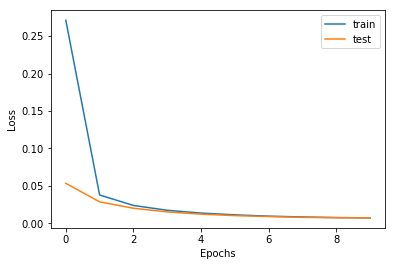

/Users/administrator/berkeleydeeprl/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


{'observations': array([[  1.25362090e+00,   4.21284441e-03,   2.81569689e-03, ...,
           2.77485796e-03,   2.34102588e-03,   2.10692364e-03],
        [  1.25309377e+00,   6.12987302e-03,   2.09639245e-03, ...,
          -1.74434740e-01,   1.20463386e+00,   1.39073273e+00],
        [  1.25170376e+00,   5.82280987e-03,  -2.42128835e-03, ...,
          -9.59457627e-01,   5.26997509e-01,   2.67435817e+00],
        ..., 
        [  1.55646613e+00,  -1.62884903e-01,   3.79360757e-03, ...,
          -3.90338344e-03,  -1.47301757e+00,  -3.58866515e-02],
        [  1.54316343e+00,  -1.75121164e-01,   3.76711719e-03, ...,
          -2.78036443e-03,  -1.51536331e+00,  -2.55183116e-02],
        [  1.52914012e+00,  -1.87510606e-01,   3.74824696e-03, ...,
          -1.98066411e-03,  -1.55456996e+00,  -1.80915179e-02]]),
 'rewards': array([ 376.9183385 ,  633.12755639,  632.24663547,  629.65889892,
         663.84846312])}

In [8]:
from models import BaselineModel
from util import plot_loss, play_env, policy_fn

baseline_model = BaselineModel(input_dim, output_dim, 
                               scalerX=scalerX, scalerY=scalerY)
baseline_model.compile(loss='mse', 
                       optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                       metrics=['mse'])
history = baseline_model.fit(trX, trY, batch_size=128, epochs=10, 
                             validation_data=[teX, teY], verbose=0)

baseline_model.summary()
plot_loss(history)

envname = 'Hopper-v2'
play_env(envname=envname, model=baseline_model)

In [9]:
tf.executing_eagerly()

False

2. Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such
as the number of demonstrations, the number of training epochs, the variance of the expert policy, or
something that you come up with yourself. For one of the tasks used in the previous question, show a
graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the
hyperparameter and a brief rationale for why you chose it in the caption for the graph.

**I chose as a hyperparameter the number of  neurons in the hidden layer. More hidden units should allow the network to map states to actions more accurately (up to some point where it probably won't lead to any improvements anymore).**

In [10]:
import warnings

returns_dict = {}
sample_size = 15
with warnings.catch_warnings() as w:
    warnings.simplefilter("ignore")
    
    for n_hidden in [8, 16, 32, 64, 124]:
        print('Hidden neurons: ', n_hidden)
        
        returns = []
        bar = tf.keras.utils.Progbar(sample_size)
        for i in range(sample_size):
            bar.update(i+1)
            model = BaselineModel(n_hidden=n_hidden, output_dim=3, 
                                  scalerX=scalerX, scalerY=scalerY)
            model.compile(loss='mse', 
                               optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                               metrics=['mse'])
            history = model.fit(trX, trY, batch_size=128, epochs=5, 
                                validation_data=[teX, teY], verbose=0)

            r = play_env(envname=envname, model=model)['rewards']
            returns.append(r)

        returns_dict[n_hidden] = returns
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        print()

Hidden neurons:  8
15/15 [==============================] - 48s 3s/step
mean return 309.707086545
std of return 299.260716776

Hidden neurons:  16
15/15 [==============================] - 65s 4s/step
mean return 877.134563891
std of return 745.994387118

Hidden neurons:  32
15/15 [==============================] - 83s 6s/step
mean return 1358.16313703
std of return 725.362315611

Hidden neurons:  64
15/15 [==============================] - 108s 7s/step
mean return 2132.65910416
std of return 1064.18060428

Hidden neurons:  124
15/15 [==============================] - 137s 9s/step
mean return 2850.73930584
std of return 1001.34615565



In [11]:
import matplotlib.pyplot as plt

data = []
for n_hidden in returns_dict:
    data.append(np.concatenate(returns_dict[n_hidden], 0))

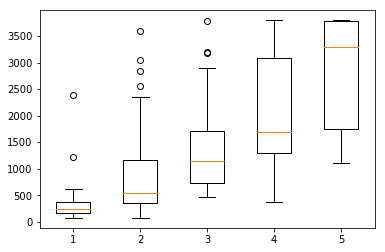

In [12]:
plt.boxplot(data)
# plt.xlabel()
plt.show()

In [72]:
np.mean(data, axis=1)

array([  309.70708654,   877.13456389,  1358.16313703,  2132.65910416,
        2850.73930584])

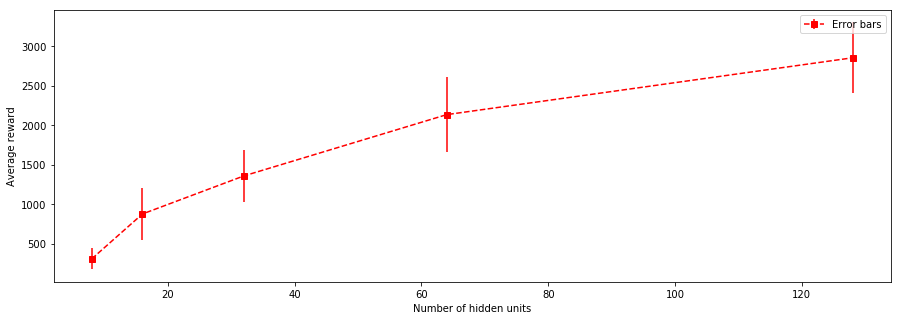

In [74]:
from util import plt_errorbars

plt_errorbars([8, 16, 32, 64, 128], np.mean(data, axis=1), 
              np.std(data, axis=1)/np.sqrt(len(data)))

# DAgger

https://www.cs.cmu.edu/~sross1/publications/Ross-AIStats11-NoRegret.pdf

1. Implement DAgger. See the code provided in run expert.py to see how to query the expert policy
and perform roll-outs in the environment.
2. Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral
cloning. Report your results in the form of a learning curve, plotting the number of DAgger iterations
vs. the policy’s mean return, with error bars to show the standard deviation. Include the performance
of the expert policy and the behavioral cloning agent on the same plot. In the caption, state which
task you used, and any details regarding network architecture, amount of data, etc. (as in the previous
section).

In [16]:
import os

os.getcwd()

'/Users/administrator/berkeleydeeprl/homework/hw1'

### Run expert for one episode to generate initial data

In [17]:
%run run_expert.py --help

usage: run_expert.py [-h] [--render] [--max_timesteps MAX_TIMESTEPS]
                     [--num_rollouts NUM_ROLLOUTS]
                     [--expert_data_file EXPERT_DATA_FILE]
                     expert_policy_file envname

positional arguments:
  expert_policy_file
  envname

optional arguments:
  -h, --help            show this help message and exit
  --render
  --max_timesteps MAX_TIMESTEPS
  --num_rollouts NUM_ROLLOUTS
                        Number of expert roll outs
  --expert_data_file EXPERT_DATA_FILE
                        Save expert data as pickle file


In [19]:
%run -i run_expert.py experts/Hopper-v1.pkl Hopper-v2 --num_rollouts=1 --expert_data_file experts/data/1rollouts.pcl

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
0/1 [..............................] - ETA: 0s

/Users/administrator/berkeleydeeprl/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


mean return 3773.28248222
std of return 0.0
Expert data saved at experts/data/1rollouts.pcl


### Helper function

In [29]:
import tf_util

def run_expert_on_obs(obs, policy_fn):
    with tf.Session():
        tf_util.initialize()
        
        actions = []
        
        for o in obs:
            a = policy_fn(o[None, :])
            actions.append(a)
            
    return np.array(actions)

### Get initial data and expert policy

In [17]:
import load_policy

initial_data = pickle.load(open('experts/data/1rollouts.pcl', 'rb'))
expert_policy = load_policy.load_policy('experts/Hopper-v1.pkl')

obs (1, 11) (1, 11)


 1/30 [>.............................] - ETA: 0s

/Users/administrator/berkeleydeeprl/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


30/30 [==============================] - 660s 22s/step


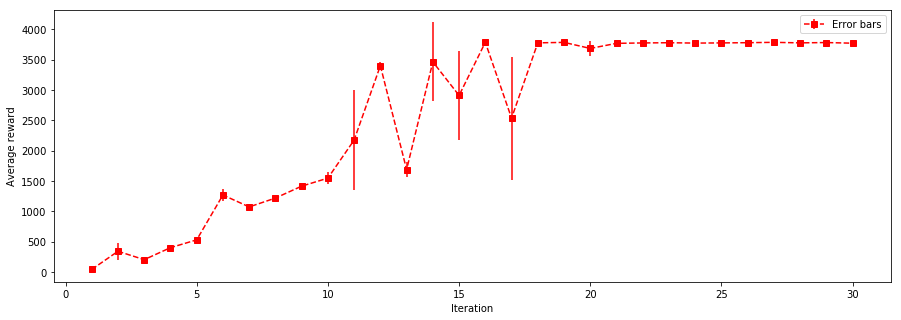

In [107]:
import tqdm
import gym.spaces
from util import train_test_scale

obs = initial_data['observations']
actions = initial_data['actions'][:, 0]

n_iter = 30
n_hidden = 64
n_output = 3
opt = tf.train.AdamOptimizer(learning_rate=0.001)

rewards = {}
num_rolls = 5

bar = tf.keras.utils.Progbar(n_iter)
for i in range(n_iter):
    bar.update(i+1)
    trX, teX, trY, teY = train_test_split(obs, actions,
                                      test_size=.1)
    # scale data
    trX, teX, trY, teY, scalerX, scalerY = train_test_scale(trX, teX, trY, teY)
    
    policy = BaselineModel(n_hidden=n_hidden, output_dim=n_output, 
                           scalerX=scalerX, scalerY=scalerY)
    policy.compile(loss='mse', optimizer=opt, 
                   metrics=['mse'])
    history = policy.fit(trX, trY, batch_size=128, epochs=5, 
#                          validation_data=[teX, teY], 
                         verbose=0)

    results = play_env(envname=envname, model=policy, num_rollouts=num_rolls)
    policy_obs = results['observations']
    rewards[i] = results['rewards']
    
    expert_actions = run_expert_on_obs(obs=policy_obs, policy_fn=expert_policy)
    
    obs = np.append(obs, policy_obs, axis=0)
    actions = np.append(actions, expert_actions.reshape(-1, n_output), axis=0)
    

plt_errorbars(list(range(1, n_iter + 1)), np.mean(list(rewards.values()), axis=1),
              yerr=np.std(list(rewards.values()), axis=1),
              xlabel='Iteration')